<div align='center'>
    <h1>Tugas Besar Dasar Kecerdasan Artificial</h1>
    <h3>Implementasi Fuzzy System untuk Klasifikasi Kualitas Udara Berdasarkan Indeks Polusi Global</h3>
</div>

<br>

<h5>Import Library </h5>

In [2]:
#import library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skfuzzy as fuzz
from skfuzzy import control as ctrl

<br>

<h5>Membaca dan Menampilkan File  CSV </h5>

In [3]:
# membaca file csv
df = pd.read_csv("cleanDataNew.csv")
fuzzy_df = df[["ta", "rh"]] # ta untuk suhu dan rh untuk kelembaban
fuzzy_df.head()

,ta,rh
0,23.0,59.0
1,24.1,32.0
2,24.1,34.0
3,23.6,44.0
4,23.4,25.0


<h5>Cek Nilai Kosong</h5>

In [4]:
# Mengecek apakah ada nilai kosong di kolom 'glucose dan BMI'
if fuzzy_df['ta'].isnull().any():
    print("Ada nilai kosong di kolom 'Temperature'.")
else:
    print("Tidak ada nilai kosong di kolom 'Temperature'.")

if fuzzy_df['rh'].isnull().any():
    print("Ada nilai kosong di kolom 'Kelembaban'.")
else:
    print("Tidak ada nilai kosong di kolom 'Kelembaban'.")

Tidak ada nilai kosong di kolom 'Temperature'.
Tidak ada nilai kosong di kolom 'Kelembaban'.


<h5>Cek Apakah Ada Outliers</h5>

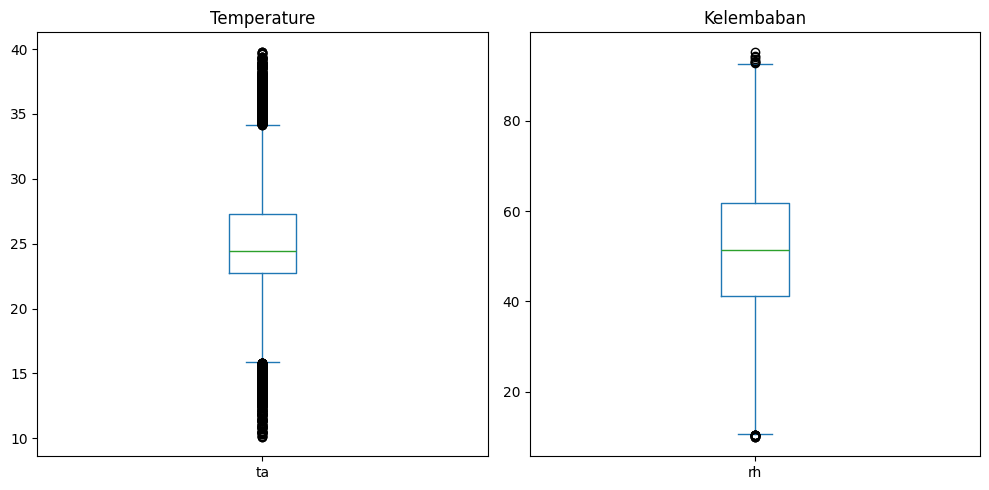

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
fuzzy_df['ta'].plot.box(ax=axes[0])
axes[0].set_title('Temperature')

fuzzy_df['rh'].plot.box(ax=axes[1])
axes[1].set_title('Kelembaban')

plt.tight_layout()
plt.show()

In [6]:
def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

In [7]:
remove = remove_outliers(fuzzy_df, ['ta', 'rh'])
fuzzy_df = remove.copy()

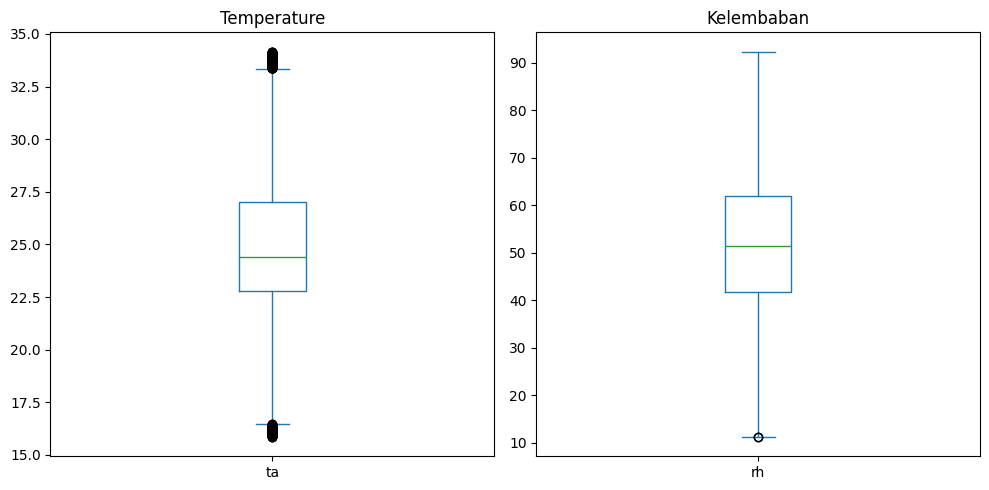

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
fuzzy_df['ta'].plot.box(ax=axes[0])
axes[0].set_title('Temperature')

fuzzy_df['rh'].plot.box(ax=axes[1])
axes[1].set_title('Kelembaban')

plt.tight_layout()
plt.show()

<h5>Variabel Linguistik</h5>

In [9]:
ta = ctrl.Antecedent(np.arange(0, 51, 1), 'temperatur')
rh = ctrl.Antecedent(np.arange(0,101, 1), 'kelembaban')
kenyamanan = ctrl.Consequent(np.arange(0, 101, 1), 'kenyamanan')

<h5>Fungsi Keanggotaan Temperatur</h5>

C:\Users\Ren\AppData\Local\Programs\Python\Python313\Lib\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


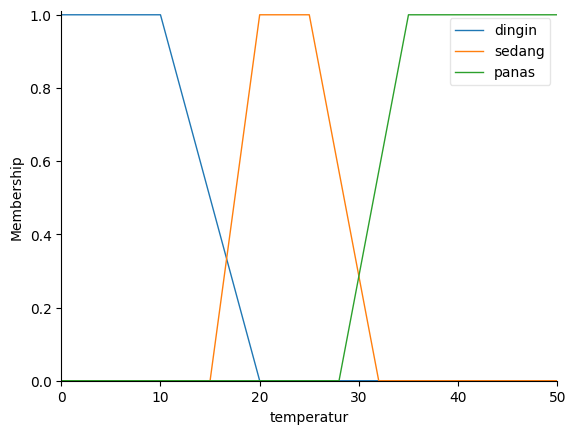

In [10]:
ta["dingin"] = fuzz.trapmf(ta.universe, [0, 0, 10, 20])
ta["sedang"] = fuzz.trapmf(ta.universe, [15, 20, 25, 32])
ta["panas"] = fuzz.trapmf(ta.universe, [28, 35, 50, 50])  # ubah trimf jadi trapmf
ta.view()

<h5>Fungsi Keanggotaan Kelembaban</h5>

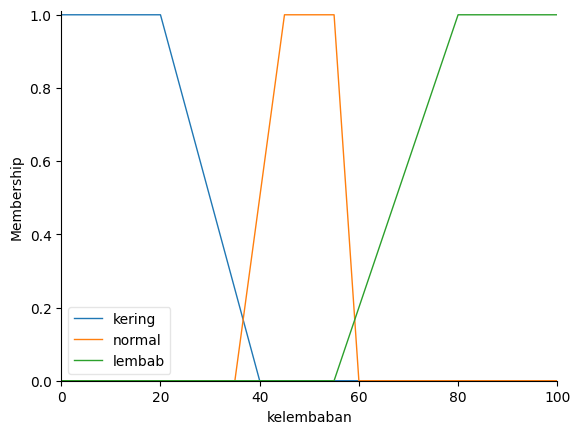

In [11]:
rh["kering"] = fuzz.trapmf(rh.universe, [0, 0, 20, 40])
rh["normal"] = fuzz.trapmf(rh.universe, [35, 45, 55, 60])
rh["lembab"] = fuzz.trapmf(rh.universe, [55, 80, 100, 100])
rh.view()

<h5>Fungsi Keanggotaan Kenyamanan</h5>

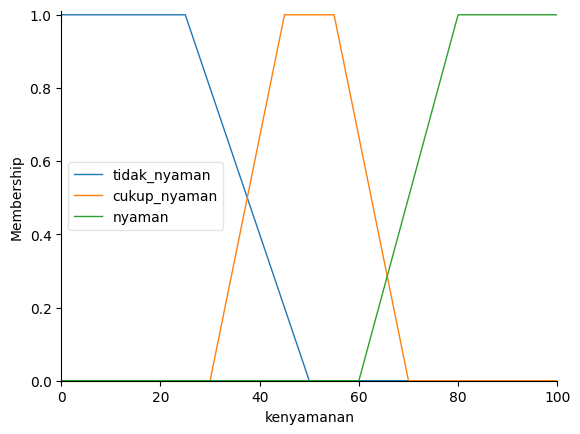

In [12]:
kenyamanan["tidak_nyaman"] = fuzz.trapmf(kenyamanan.universe, [0, 0, 25, 50])
kenyamanan["cukup_nyaman"] = fuzz.trapmf(kenyamanan.universe, [30, 45, 55, 70])
kenyamanan["nyaman"]       = fuzz.trapmf(kenyamanan.universe, [60, 80, 100, 100])
kenyamanan.view()

<h5>Aturan Fuzy</h5>

In [13]:
rule1 = ctrl.Rule(ta['dingin'] & rh['kering'], kenyamanan['tidak_nyaman'])
rule2 = ctrl.Rule(ta['dingin'] & rh['normal'], kenyamanan['cukup_nyaman'])
rule3 = ctrl.Rule(ta['dingin'] & rh['lembab'], kenyamanan['tidak_nyaman'])
rule4 = ctrl.Rule(ta['sedang'] & rh['kering'], kenyamanan['cukup_nyaman'])
rule5 = ctrl.Rule(ta['sedang'] & rh['normal'], kenyamanan['nyaman'])
rule6 = ctrl.Rule(ta['sedang'] & rh['lembab'], kenyamanan['cukup_nyaman'])
rule7 = ctrl.Rule(ta['panas'] & rh['kering'], kenyamanan['tidak_nyaman'])
rule8 = ctrl.Rule(ta['panas'] & rh['normal'], kenyamanan['cukup_nyaman'])
rule9 = ctrl.Rule(ta['panas'] & rh['lembab'], kenyamanan['tidak_nyaman'])
# Penggabuangan Aturan
kenyamanan_ctrl = ctrl.ControlSystem([
    rule1, rule2, rule3,
    rule4, rule5, rule6,
    rule7, rule8, rule9
])

<h5>Control dan Simulasi</h5>

Hasil inferensi kenyamanan: 22.02


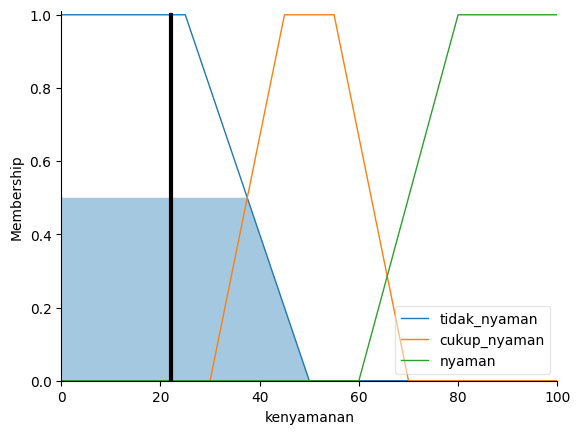

In [14]:
kenyamanan_simulation = ctrl.ControlSystemSimulation(kenyamanan_ctrl)
# Contoh input
kenyamanan_simulation.input['temperatur'] = 15
kenyamanan_simulation.input['kelembaban'] = 10

# Proses inferensi
kenyamanan_simulation.compute()

print(f"Hasil inferensi kenyamanan: {kenyamanan_simulation.output['kenyamanan']:.2f}")
kenyamanan.view(sim=kenyamanan_simulation)

<h5>Menambahkan hasil ke Data Frame</h5>

In [15]:
hasil = []
for i, row in fuzzy_df.iterrows():
    suhu = row['ta']
    lembab = row['rh']
    kenyamanan_simulation.input['temperatur'] = suhu
    kenyamanan_simulation.input['kelembaban'] = lembab
    kenyamanan_simulation.compute()
    hasil.append(kenyamanan_simulation.output['kenyamanan'])

fuzzy_df['kenyamanan'] = hasil

In [16]:
fuzzy_df.head()

,ta,rh,kenyamanan
0,23.0,59.0,67.487948
1,24.1,32.0,50.000000
2,24.1,34.0,50.000000
3,23.6,44.0,84.064516
4,23.4,25.0,50.000000
